### This is a notebook to give an overview of what is possible with the N2N4M package, for denoising and visualising CRISM L sensor images.

In [1]:
# Some standard imports
import os
import matplotlib.pyplot as plt
import urllib.request

# Some imports from within the N2N4M package
from n2n4m.crism_image import CRISMImage # Class to read, process and write out CRISM images
from n2n4m.plot import Visualiser, InteractiveVisualiser # Class to plot CRISM images, and for interactive plots in Jupyter notebooks
from n2n4m.wavelengths import ALL_WAVELENGTHS # A list of all CRISM wavelengths

This tutorial requires a downloaded CRISM L sensor image. We recommend you use the [Orbital Data Explorer](https://ode.rsl.wustl.edu/mars/index.aspx) or [MarsSI](https://marssi.univ-lyon1.fr/wiki/Home) to find imagery.  
You can create an account with MarsSI for free [here](https://marssi.univ-lyon1.fr/). Details of how to select, process and download CRISM imagery are given [here](https://marssi.univ-lyon1.fr/wiki/CRISM). This tutorial assumes CAT processing has been applied to the image, which MarsSI does (to create the CAT_corr.img file). If you use the Orbital Data Explorer, you will need to apply CAT processing yourself with the CAT tool in ENVI. 

Please download a CRSIM L sensor image and save it in the data/example_image folder. As an example, we will use this image:
atu0003561f_01_if166l_trr3.img  
The image is from the CRISM L sensor, and is of a region of Oxia Planum.  
Please ensure the filename of the image matches the filename in the .lbl file.  
If using MarsSI, this involves changing the .img filename to remove the _CAT_corr suffix.  

To load the image, simply create an instance of CRISMImage, and pass the path to the .img file as an argument.

In [2]:
DATA_DIR = "../data/example_image/"
image_name = "ATU0003561F_01_IF168L_TRR3.img" # Change this to the name of whichever image you want to use
image_path = os.path.join(DATA_DIR, image_name)
example_image = CRISMImage(image_path)

Image loaded successfully.


With this object, we can examine information about the image.

In [3]:
# Get a description of the image
print(
    f"Image Name: {example_image.im_name}\n"
    f"Spatial dimensions: {example_image.spatial_dims}\n"
    f"Number of bands: {example_image.num_bands}\n"
)

Image Name: ATU0003561F
Spatial dimensions: (151, 640)
Number of bands: 438



If we pass this object to a Visualiser, we can then examine the image.

In [4]:
vis = Visualiser(example_image)

/home/rob_platt/N2N4M/N2N4M/n2n4m/plot.py:105: UserWarning: Bad values detected in the image. A copy has been made, values > 1000 will be replaced with np.nan.
  warnings.warn(


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Example Image Band 60'}>)

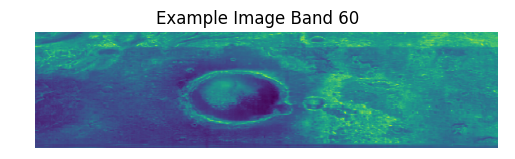

In [5]:
# Plot band 60 from the image
im_slice = vis.get_image(60)
vis.plot_image(im_slice, title="Example Image Band 60")

Notice a Warning that bad values (in CRISM typically 65535) exist in the image we attempted to plot. These are replaced by NaNs for plotting, but applied to a copy of the data, so the original is not affected.

(<Figure size 400x250 with 1 Axes>,
 <Axes: title={'center': 'Example Image Spectrum'}, xlabel='Wavelength (μm)', ylabel='Reflectance (I/F)'>)

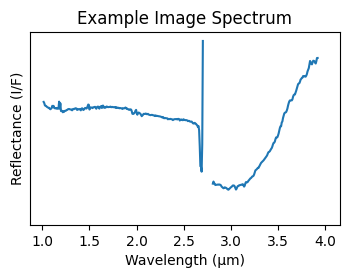

In [6]:
# Plot a spectrum from the image
spectrum = vis.get_raw_spectrum((100, 100))
vis.plot_spectrum(spectrum, bands=ALL_WAVELENGTHS, title="Example Image Spectrum")

If you only wish to display a portion of the spectrum, you can slice the spectrum and band list however you like.

(<Figure size 400x250 with 1 Axes>,
 <Axes: title={'center': 'Example Image Spectrum'}, xlabel='Wavelength (μm)', ylabel='Reflectance (I/F)'>)

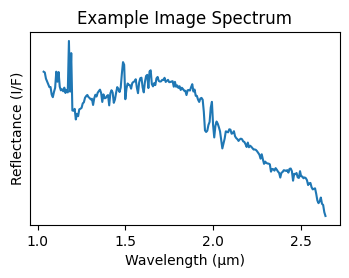

In [16]:
spectrum = vis.get_raw_spectrum((100, 100))
vis.plot_spectrum(spectrum[5:250], bands=ALL_WAVELENGTHS[5:250], title="Example Image Spectrum")

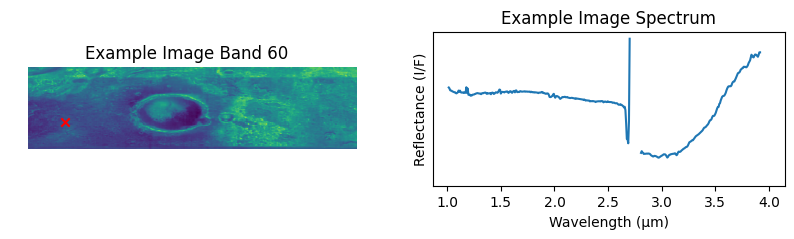

In [7]:
# If axes are passed to the plot methods, they will be drawn on those axes.
fig, ax = plt.subplots(1, 2, figsize=(10, 2))
vis.plot_image(im_slice, title="Example Image Band 60", ax=ax[0])
vis.plot_spectrum(spectrum, bands=ALL_WAVELENGTHS, title="Example Image Spectrum", ax=ax[1])
ax[0].scatter(100, 100, color="red", marker="x") # Add a marker to the image of the spectrum location

We can also use the CRISMImage object to perform some numerical operations - image ratioing, and summary parameter calculation.

In [8]:
# We can ratio the image, to remove column-consistent features, denoise, and enhance unusual spectral features.
# This uses the model and method described in: https://github.com/Banus/crism_ml/blob/master/crism_ml/preprocessing.py
# For that we need to have the training data for the model.
CRISM_ML_DATA = "http://cs.iupui.edu/~mdundar/CRISM/CRISM_bland_unratioed.mat"
CRISM_ML_LOCAL_DATA_DIR = "../data/CRISM_ML/"
if not os.path.exists(CRISM_ML_LOCAL_DATA_DIR):
    os.makedirs(CRISM_ML_LOCAL_DATA_DIR)

if not os.path.exists(os.path.join(CRISM_ML_LOCAL_DATA_DIR, "CRISM_bland_unratioed.mat")):
    urllib.request.urlretrieve(CRISM_ML_DATA, os.path.join(CRISM_ML_LOCAL_DATA_DIR, "CRISM_bland_unratioed.mat"))

In [9]:
# We can now ratio the image
example_image.ratio_image(CRISM_ML_LOCAL_DATA_DIR) # Need to pass the path to the training data. This make take a few minutes to run the first time.

/home/rob_platt/N2N4M/N2N4M/n2n4m/preprocessing.py:243: RuntimeWarning: Mean of empty slice
  image_copy = np.nan_to_num(image_copy, nan=np.nanmean(image_copy, axis=0))
/home/rob_platt/anaconda3/envs/test/lib/python3.11/site-packages/crism_ml/preprocessing.py:410: RuntimeWarning: invalid value encountered in divide
  normed = pixspec[idx, :, :] / bland


In [10]:
# From the ratioed image, we can calculate summary parameters. These are used as proxies to highlight specific mineral features.
example_image.calculate_summary_parameter("hyd_femg_clay_index") # This summary parameter is used to highlight hydrated Fe-Mg clays e.g. Saponite.

/home/rob_platt/N2N4M/N2N4M/n2n4m/summary_parameters.py:139: RuntimeWarning: invalid value encountered in divide
  band_depth = center_ref / interpolated_center_ref


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Hydrated Fe-Mg Clay Index'}>)

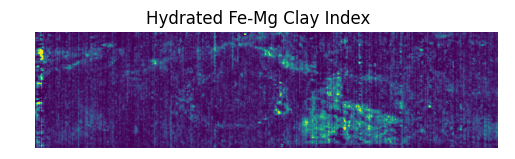

In [11]:
# We can now make a new visualiser, to plot all of these new features.
vis = Visualiser(example_image)

clay_summ_param = vis.get_summary_parameter("hyd_femg_clay_index")
vis.plot_image(clay_summ_param, title="Hydrated Fe-Mg Clay Index")

(<Figure size 1000x200 with 2 Axes>,
 <Axes: title={'center': 'Ratioed Spectrum'}, xlabel='Wavelength (μm)', ylabel='Reflectance (I/F)'>)

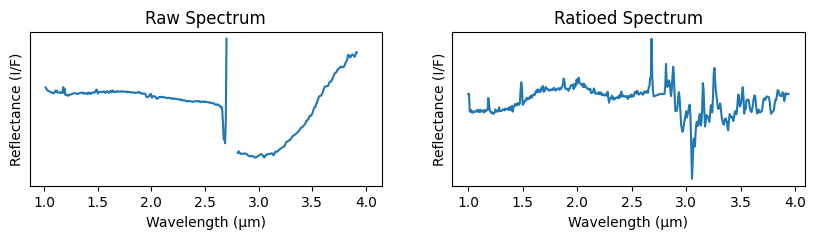

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10, 2))
raw_spectrum = vis.get_raw_spectrum((100, 100))
ratioed_spectrum = vis.get_ratioed_spectrum((100, 100))
vis.plot_spectrum(raw_spectrum, bands=ALL_WAVELENGTHS, title="Raw Spectrum", ax=ax[0])
vis.plot_spectrum(ratioed_spectrum, bands=ALL_WAVELENGTHS, title="Ratioed Spectrum", ax=ax[1])

In a Jupyter notebook, we can also create an interactive visualisation, to dynamically plot the image and spectra.  
X and Y sliders allow us to move around the image, and the spectra are plotted for the pixel at the current X and Y position.  
Image Band controls which band of the image to plot.  
Image Options displays any additional images that have been added to the visualiser, such as the summary parameters.  
Spectrum Bands controls the range of bands to plot, from 1-438. Imput as a range, e.g. 1-250.  
Spectrum Type controls whether you wish to plot the raw, or ratioed spectra.

In [15]:
interactive_vis = InteractiveVisualiser(example_image)
interactive_vis.interactive_plot()